#  sqdet with OpenLane

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple digital inverter design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

In [5]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


Empty environment created at prefix: /content/conda-env

Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - openlane=*
   - open_pdks.sky130a=*


  Package                                                Version  Build                 Channel        Size
─────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────────────────────────────────────

  + open_pdks.sky130a                         1.0.460_0_gfdb1863  20231104_052339       litex-hub       1GB
  + _libgcc_mutex                                            0.1  main                  main            3kB
  + libstdcxx-ng                                          11.2.0  h1234567_1            main            6MB
  + ld_impl_linux-64                                        2.38  h1181459_1            main          749kB
  + ca-certificates            

## Write verilog

In [13]:
%%writefile sqdet.v


module sqdet(input din, clk, rst,
                output reg dout);

reg [3:0]ps,ns;
parameter  R= 4'b0000,A0 = 4'b0001,A1 = 4'b0010,A2 = 4'b0011,A3 = 4'b0100,A4 = 4'b0101,A5 =4'b0110,A6=4'b0111,A7=4'b1000;


always@ (posedge clk or negedge rst) begin

    if(!rst)

        ps<=R;

  else
			ps<=ns;
	end
always@(ps or din)
begin
    case(ps)
        R:begin

          if(din==0) ns=A1;
          else ns=A0;
         end
        A0:begin

          if(din==0) ns=A4;
          else ns=A0;
         end
        A1:begin

          if(din==0) ns=A1;
          else ns=A2;
         end
        A2:begin

          if(din==0) ns=A3;
          else ns=A0;
         end
        A3:begin

          if(din==0) ns=A6;
          else ns=A2;
         end
        A4:begin

          if(din==0) ns=A5;
          else ns=A2;
         end
        A5:begin

          if(din==0) ns=A1;
          else ns=A7;
         end
         A6:begin


          if(din==0) ns=A1;
          else ns=A7;
         end
         A7:begin

          if(din==0) ns=A3;
          else ns=A0;
         end
        default:ns=R;
    endcase
end
always@(ps,din)begin

	case(ps)
		A6:dout=1;
		A7:dout=1;
		default:dout=0;
	endcase
end
endmodule


Overwriting sqdet.v


## Write configuration

[Documentation](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In [14]:
%%writefile config.json
{
    "DESIGN_NAME": "sqdet",
    "VERILOG_FILES": "dir::sqdet.v",
    "RUN_CTS": 1,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 34.5 57.12",
    "PL_TARGET_DENSITY": 0.75,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "GRT_REPAIR_ANTENNAS": 1,
    "RUN_HEURISTIC_DIODE_INSERTION": 0
}

Overwriting config.json


## Run OpenLane Flow

[OpenLane](https://openlane.readthedocs.io/en/latest/) is an automated [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) to [GDSII](https://en.wikipedia.org/wiki/GDSII) flow based on several components including [OpenROAD](https://theopenroadproject.org/), [Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/) and custom methodology scripts for design exploration and optimization targeting [open source PDKs](https://github.com/google/open-source-pdks).

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

In [8]:
!pip install libparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00


In [15]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2023.11.03_0_gf4f8dad8-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /content/runs/RUN_2024.02.11_16.32.02
[INFO]: Saving runtime environment...
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[WARNING]: PNR_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[WARNING]: SIGNOFF_SDC_FILE is not set. It is recommended to write a custom SDC file for the design. Defaulting to BASE_SDC_FILE
[INFO]: Running linter (Verilator) (log: 

## Linter Log File

In [16]:
import pathlib

# Define the path to the directory containing the log files
log_directory = pathlib.Path('runs')

# Find all log files
reports = sorted(log_directory.glob('*/logs/synthesis/linter.log'))

if reports:
    # Open and read the log file
    try:
        with open(reports[-1], 'r') as log_file:
            # Read the contents of the log file
            log_contents = log_file.read()
            print(log_contents)
    except FileNotFoundError:
        print("Log file not found.")
else:
    print("No log files found.")

## Display layout

## STA Report

Check Files tab in Colab, it has all the files which got created under latest RUN_* in runs dir/

Do checkout this [link](https://techhenzy.com/timing-closure/) for more STA info

In [17]:

# Print your STA report here
import pathlib

# Define the path to the 'runs' directory
runs_path = pathlib.Path('runs')

# Get all directories within the 'runs' path
all_dirs = [entry.name for entry in runs_path.iterdir() if entry.is_dir()]

# Print the names of all directories
for dir_name in all_dirs:
    print(dir_name)

reports = sorted(runs_path.glob('*/reports/routing/*_sta.max.rpt'))

if reports:
    # Open and read the log file
    try:
        with open(reports[-1], 'r') as STA_file:
            # Read the contents of the log file
            sta_contents = STA_file.read()
            print(sta_contents)
    except FileNotFoundError:
        print("STA file not found.")
else:
    print("No sta files found.")

RUN_2024.02.11_16.28.18
RUN_2024.02.11_16.32.02
RUN_2024.02.11_16.31.25

report_checks -path_delay max (Setup)
======================= Typical Corner ===================================

No paths found.

worst slack corner Typical: INF



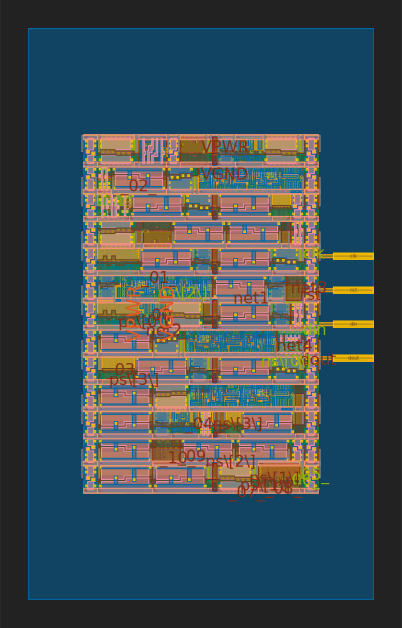

In [18]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('sqdet.svg')
IPython.display.SVG('sqdet.svg')

## Metrics

[Documentation](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)


In [19]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))

df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,sqdet
config,RUN_2024.02.11_16.32.02
flow_status,flow completed
total_runtime,0h2m3s0ms
routed_runtime,0h1m42s0ms
(Cell/mm^2)/Core_Util,24357.569115
DIEAREA_mm^2,0.001971
CellPer_mm^2,12178.784557
OpenDP_Util,-1


No charts were generated by quickchart
